In [ ]:
# ============ IMPORTS ============
import os, json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_score, recall_score, f1_score, accuracy_score,
                             matthews_corrcoef, make_scorer,
                             ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay,precision_recall_curve)

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from IPython.display import display

Mounted at /content/drive


In [ ]:
# ============ CONFIG ============
SAVE_DIR = "./artifacts"
os.makedirs(SAVE_DIR, exist_ok=True)
TARGET = "churn"
RANDOM_STATE = 42
N_JOBS = -1

In [ ]:
# ============ LOAD DATA ============
df = pd.read_csv("Churn-data-UCI Dataset(5000).csv")
df = df.rename(columns=lambda c: c.strip())

print(df.info())
print(df.head())
print(df[TARGET].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   churn                       5000 non-null   bool   
 1   accountlength               5000 non-null   int64  
 2   internationalplan           5000 non-null   bool   
 3   voicemailplan               5000 non-null   bool   
 4   numbervmailmessages         5000 non-null   int64  
 5   totaldayminutes             5000 non-null   float64
 6   totaldaycalls               5000 non-null   int64  
 7   totaldaycharge              5000 non-null   float64
 8   totaleveminutes             5000 non-null   float64
 9   totalevecalls               5000 non-null   int64  
 10  totalevecharge              5000 non-null   float64
 11  totalnightminutes           5000 non-null   float64
 12  totalnightcalls             5000 non-null   int64  
 13  totalnightcharge            5000 

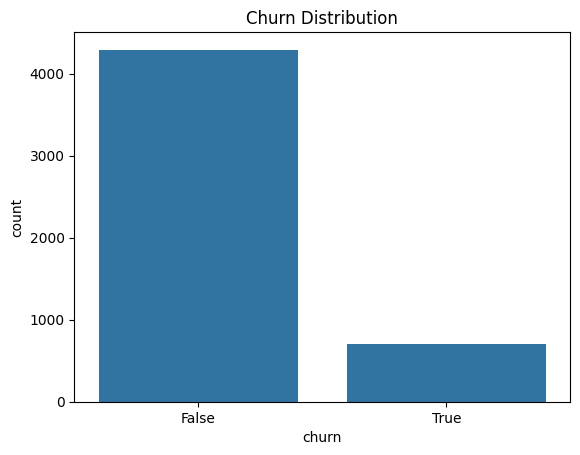

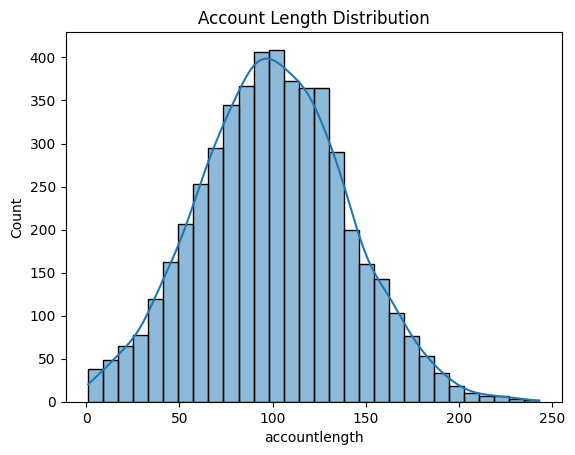

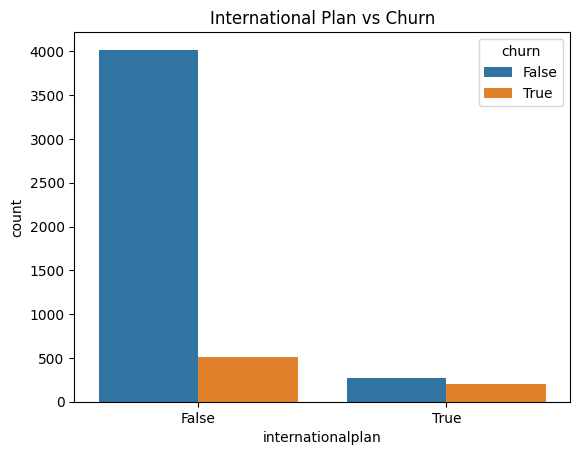

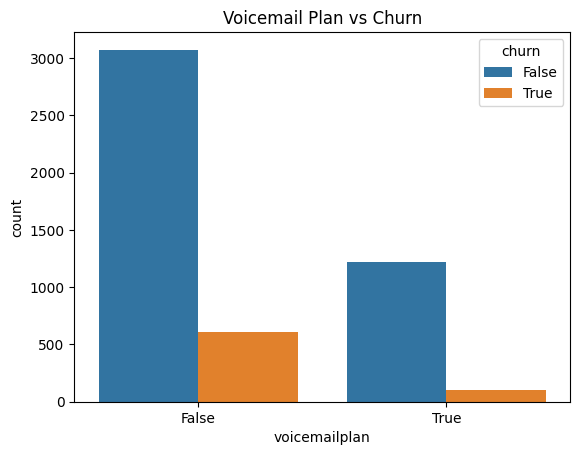

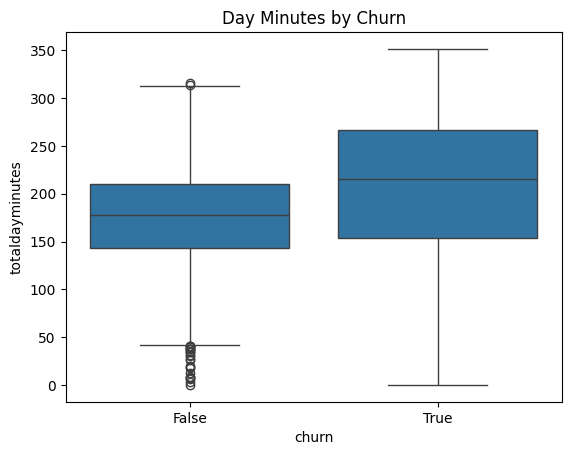

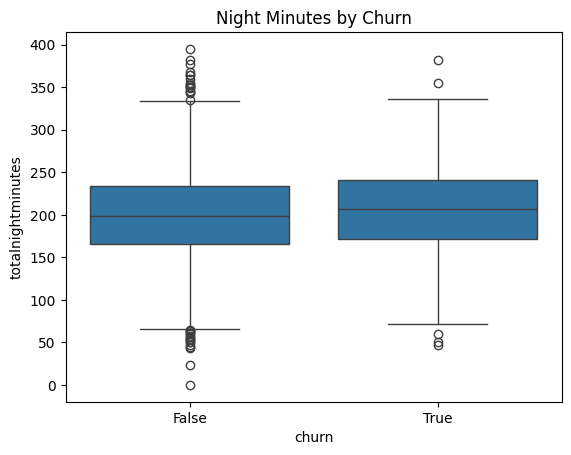

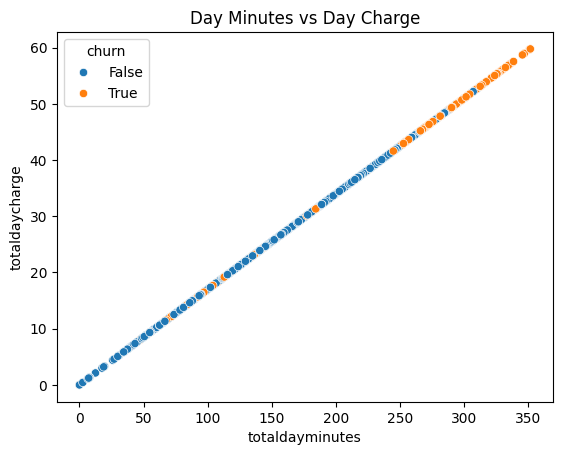

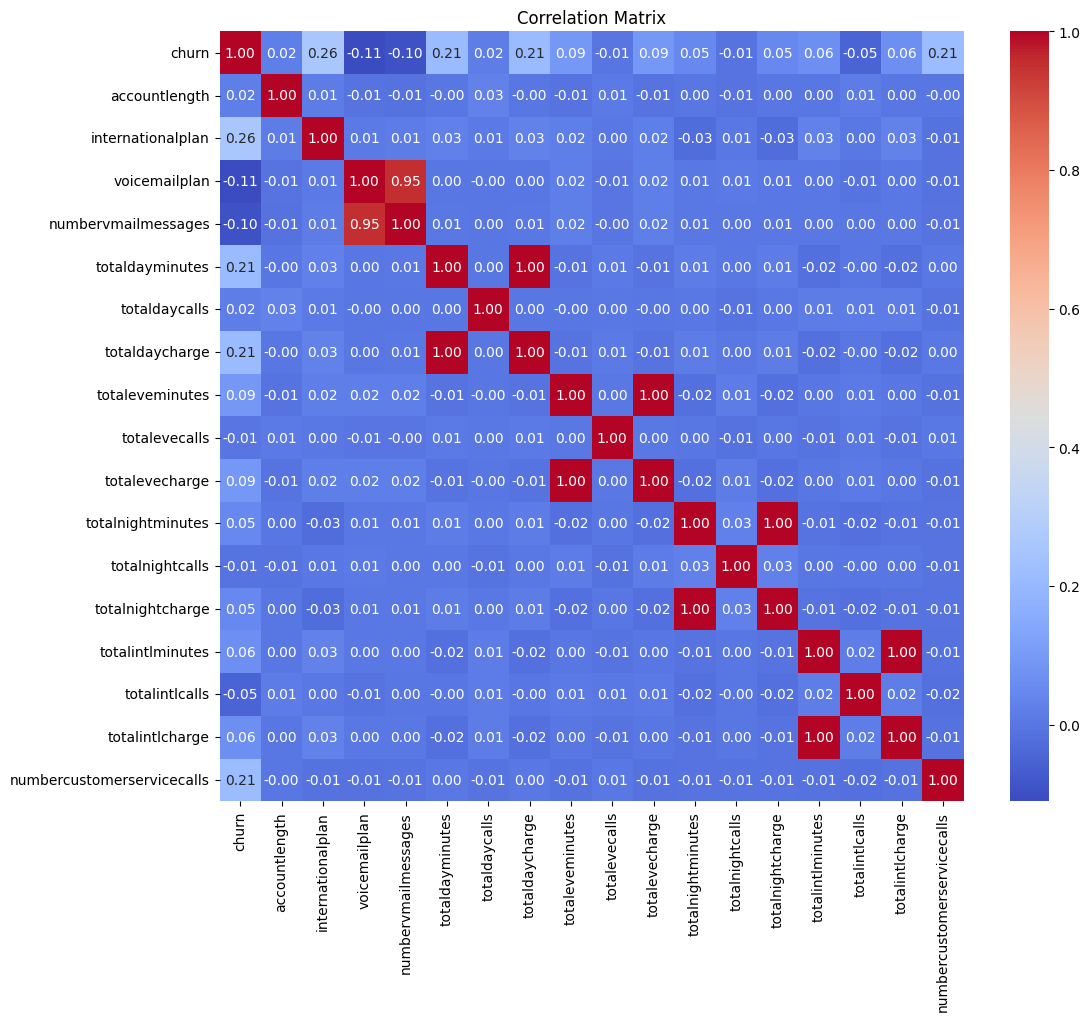

In [ ]:
# ============ EDA ============
sns.countplot(x=TARGET, data=df)
plt.title("Churn Distribution")
plt.show()

sns.histplot(df['accountlength'], bins=30, kde=True)
plt.title("Account Length Distribution")
plt.show()

sns.countplot(x='internationalplan', hue=TARGET, data=df)
plt.title("International Plan vs Churn")
plt.show()

sns.countplot(x='voicemailplan', hue=TARGET, data=df)
plt.title("Voicemail Plan vs Churn")
plt.show()

sns.boxplot(x=TARGET, y='totaldayminutes', data=df)
plt.title("Day Minutes by Churn")
plt.show()

sns.boxplot(x=TARGET, y='totalnightminutes', data=df)
plt.title("Night Minutes by Churn")
plt.show()

sns.scatterplot(x='totaldayminutes', y='totaldaycharge', hue=TARGET, data=df)
plt.title("Day Minutes vs Day Charge")
plt.show()

corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [ ]:
# ============ FEATURE ENGINEERING ============
# Binary encoding
df[TARGET] = df[TARGET].map({True:1, False:0, 'Yes':1, 'No':0, 'yes':1, 'no':0}).astype(int)
df['internationalplan'] = df['internationalplan'].map({True:1, False:0, 'yes':1, 'no':0}).fillna(0)
df['voicemailplan'] = df['voicemailplan'].map({True:1, False:0, 'yes':1, 'no':0}).fillna(0)

# Aggregated features
day_charge_cols = [c for c in ['totaldaycharge','totalevecharge','totalnightcharge','totalintlcharge'] if c in df.columns]
min_cols = [c for c in ['totaldayminutes','totaleveminutes','totalnightminutes','totalintlminutes'] if c in df.columns]
call_cols = [c for c in ['totaldaycalls','totalevecalls','totalnightcalls','totalintlcalls'] if c in df.columns]

df['total_charge'] = df[day_charge_cols].sum(axis=1)
df['total_minutes'] = df[min_cols].sum(axis=1)
df['total_calls'] = df[call_cols].sum(axis=1)

df['day_minutes_per_call'] = df['totaldayminutes'] / (df['totaldaycalls']+1e-5)
df['eve_minutes_per_call'] = df['totaleveminutes'] / (df['totalevecalls']+1e-5)
df['night_minutes_per_call'] = df['totalnightminutes'] / (df['totalnightcalls']+1e-5)
df['intl_minutes_per_call'] = df['totalintlminutes'] / (df['totalintlcalls']+1e-5)

df['service_call_frequency'] = df['numbercustomerservicecalls'] / (df['accountlength']+1)
df['charge_per_minute'] = df['total_charge'] / (df['total_minutes']+1e-5)

# Fill missing values
for c in df.select_dtypes(include=[np.number]).columns:
    df[c] = df[c].fillna(df[c].median())
# View newly engineered features
df.head()

,churn,accountlength,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,...,numbercustomerservicecalls,total_charge,total_minutes,total_calls,day_minutes_per_call,eve_minutes_per_call,night_minutes_per_call,intl_minutes_per_call,service_call_frequency,charge_per_minute
0,0,128,0,1,25,265.1,110,45.07,197.4,99,...,1,75.56,717.2,303,2.410000,1.993939,2.689011,3.333322,0.007752,0.105354
1,0,107,0,1,26,161.6,123,27.47,195.5,103,...,1,59.24,625.2,332,1.313821,1.898058,2.469903,4.566651,0.009259,0.094754
2,0,137,0,0,0,243.4,114,41.38,121.2,110,...,0,62.29,539.4,333,2.135088,1.101818,1.563461,2.439995,0.000000,0.115480
3,0,84,1,0,0,299.4,71,50.90,61.9,88,...,2,66.80,564.8,255,4.216901,0.703409,2.212359,0.942856,0.023529,0.118272
4,0,75,1,0,0,166.7,113,28.34,148.3,122,...,3,52.09,512.0,359,1.475221,1.215574,1.544628,3.366655,0.039474,0.101738


In [ ]:
# ============ Train / Test Split ============
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


In [ ]:
# ============ Model Definitions, Best parameters, and Sampling Method  ============
best_params = {
    "RF": {"n_estimators":300, "max_depth":12, "min_samples_leaf":3, "random_state":RANDOM_STATE},
    "GB": {"n_estimators":200, "learning_rate":0.1, "max_depth":3, "random_state":RANDOM_STATE},
    "LR": {"C":1, "penalty":"l2", "solver":"liblinear", "random_state":RANDOM_STATE}
}

models = {"RF": RandomForestClassifier, "GB": GradientBoostingClassifier, "LR": LogisticRegression}

samplers = {"SMOTE": SMOTE(random_state=RANDOM_STATE),
            "SMOTEENN": SMOTEENN(random_state=RANDOM_STATE),
            "SMOTETomek": SMOTETomek(random_state=RANDOM_STATE)}


In [ ]:
# ============ FUNCTION ============
def run_experiment(model_name, sampler_name, resampler):
    exp_name = f"{model_name}_{sampler_name}"
    model_path = os.path.join(SAVE_DIR, f"{exp_name}_pipeline.pkl")
    meta_path = os.path.join(SAVE_DIR, f"{exp_name}_meta.json")

    if os.path.exists(model_path) and os.path.exists(meta_path):
        print(f"🔄 Loading saved model: {exp_name}")
        best_pipe = joblib.load(model_path)
        with open(meta_path,"r") as f: meta = json.load(f)
    else:
        print(f"🚀 Training: {exp_name}")
        tuned_clf = models[model_name](**best_params[model_name])
        pipe = ImbPipeline([("preproc", preprocessor), ("resample", resampler), ("clf", tuned_clf)])
        pipe.fit(X_train, y_train)
        joblib.dump(pipe, model_path)

        y_train_prob = cross_val_predict(pipe, X_train, y_train, cv=3, method="predict_proba")[:,1]
        prec, rec, thresh = precision_recall_curve(y_train, y_train_prob)
        f1s = 2*prec*rec/(prec+rec+1e-12)
        best_idx = np.argmax(f1s)
        best_thresh = float(thresh[best_idx]) if best_idx < len(thresh) else 0.5

        meta = {
            "best_params": best_params[model_name],
            "best_threshold": best_thresh
        }
        with open(meta_path,"w") as f: json.dump(meta,f)
        best_pipe = pipe

    y_test_prob = best_pipe.predict_proba(X_test)[:,1]
    y_test_pred = (y_test_prob >= meta["best_threshold"]).astype(int)

    # 10-fold CV Accuracy
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    cv_acc = cross_val_score(best_pipe, X, y, cv=cv, scoring="accuracy", n_jobs=N_JOBS)
    cv_f1 = cross_val_score(best_pipe, X, y, cv=cv, scoring="f1", n_jobs=N_JOBS)

    res = {
        "model": model_name,
        "sampler": sampler_name,
        "roc_auc": roc_auc_score(y_test, y_test_prob),
        "f1": f1_score(y_test, y_test_pred),
        "precision": precision_score(y_test, y_test_pred),
        "recall": recall_score(y_test, y_test_pred),
        "accuracy": accuracy_score(y_test, y_test_pred),
        "cv_accuracy_mean": cv_acc.mean(),
        "cv_accuracy_std": cv_acc.std(),
        "cv_f1_mean": cv_f1.mean(),
        "cv_f1_std": cv_f1.std(),
        "mcc": matthews_corrcoef(y_test, y_test_pred),
        "confusion_matrix": confusion_matrix(y_test, y_test_pred),
        "probs": y_test_prob
    }
    return res

In [ ]:
# ===== Run all model–sampler combinations and save results =====
all_results = []
for mname in models.keys():
    for sname,sampler in samplers.items():
        res = run_experiment(mname, sname, sampler)
        all_results.append(res)

summary_df = pd.DataFrame(all_results)
summary_df.to_csv(os.path.join(SAVE_DIR,"summary_results.csv"), index=False)
print(summary_df)



🚀 Training: RF_SMOTE
🚀 Training: RF_SMOTEENN
🚀 Training: RF_SMOTETomek
🚀 Training: GB_SMOTE
🚀 Training: GB_SMOTEENN
🚀 Training: GB_SMOTETomek
🚀 Training: LR_SMOTE
🚀 Training: LR_SMOTEENN
🚀 Training: LR_SMOTETomek
  model     sampler   roc_auc        f1  precision    recall  accuracy  \
0    RF       SMOTE  0.914629  0.920755   0.983871  0.865248     0.979   
1    RF    SMOTEENN  0.916776  0.862319   0.881481  0.843972     0.962   
2    RF  SMOTETomek  0.918436  0.917293   0.976000  0.865248     0.978   
3    GB       SMOTE  0.925891  0.909091   0.975610  0.851064     0.976   
4    GB    SMOTEENN  0.924058  0.883721   0.974359  0.808511     0.970   
5    GB  SMOTETomek  0.927567  0.909091   0.975610  0.851064     0.976   
6    LR       SMOTE  0.843955  0.523077   0.461957  0.602837     0.845   
7    LR    SMOTEENN  0.843526  0.516971   0.409091  0.702128     0.815   
8    LR  SMOTETomek  0.844162  0.523077   0.461957  0.602837     0.845   

   cv_accuracy_mean  cv_accuracy_std  cv_f1_me

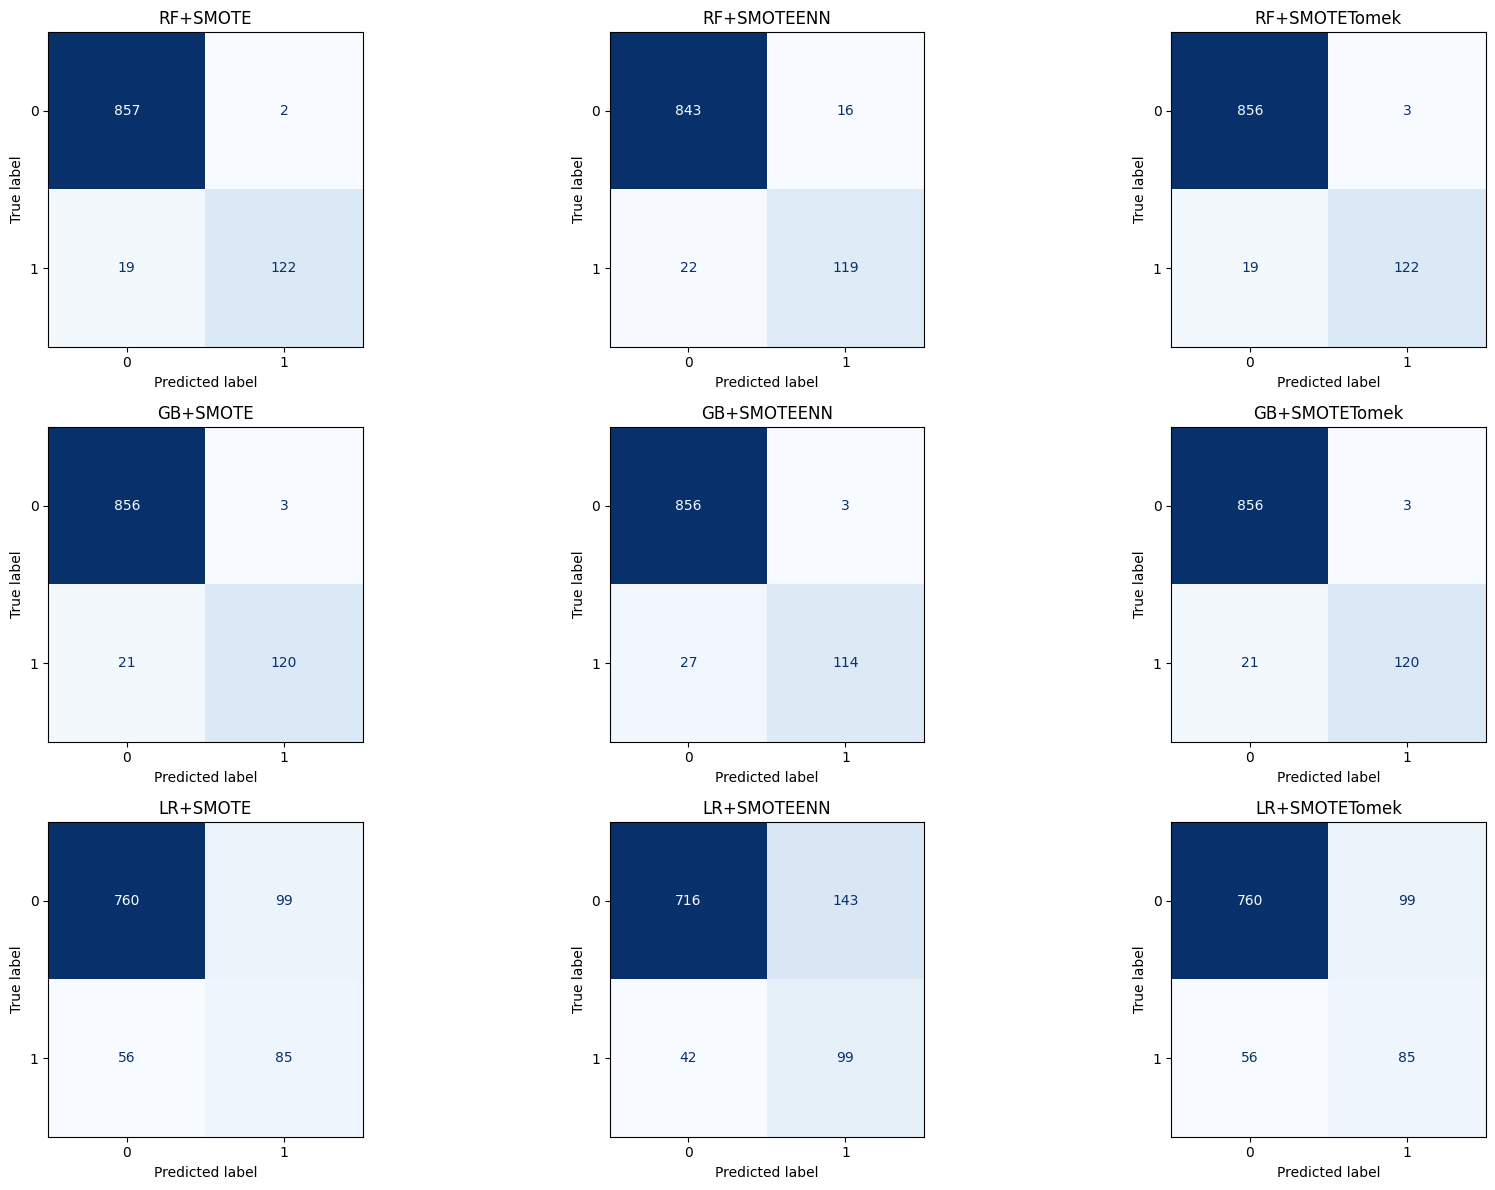

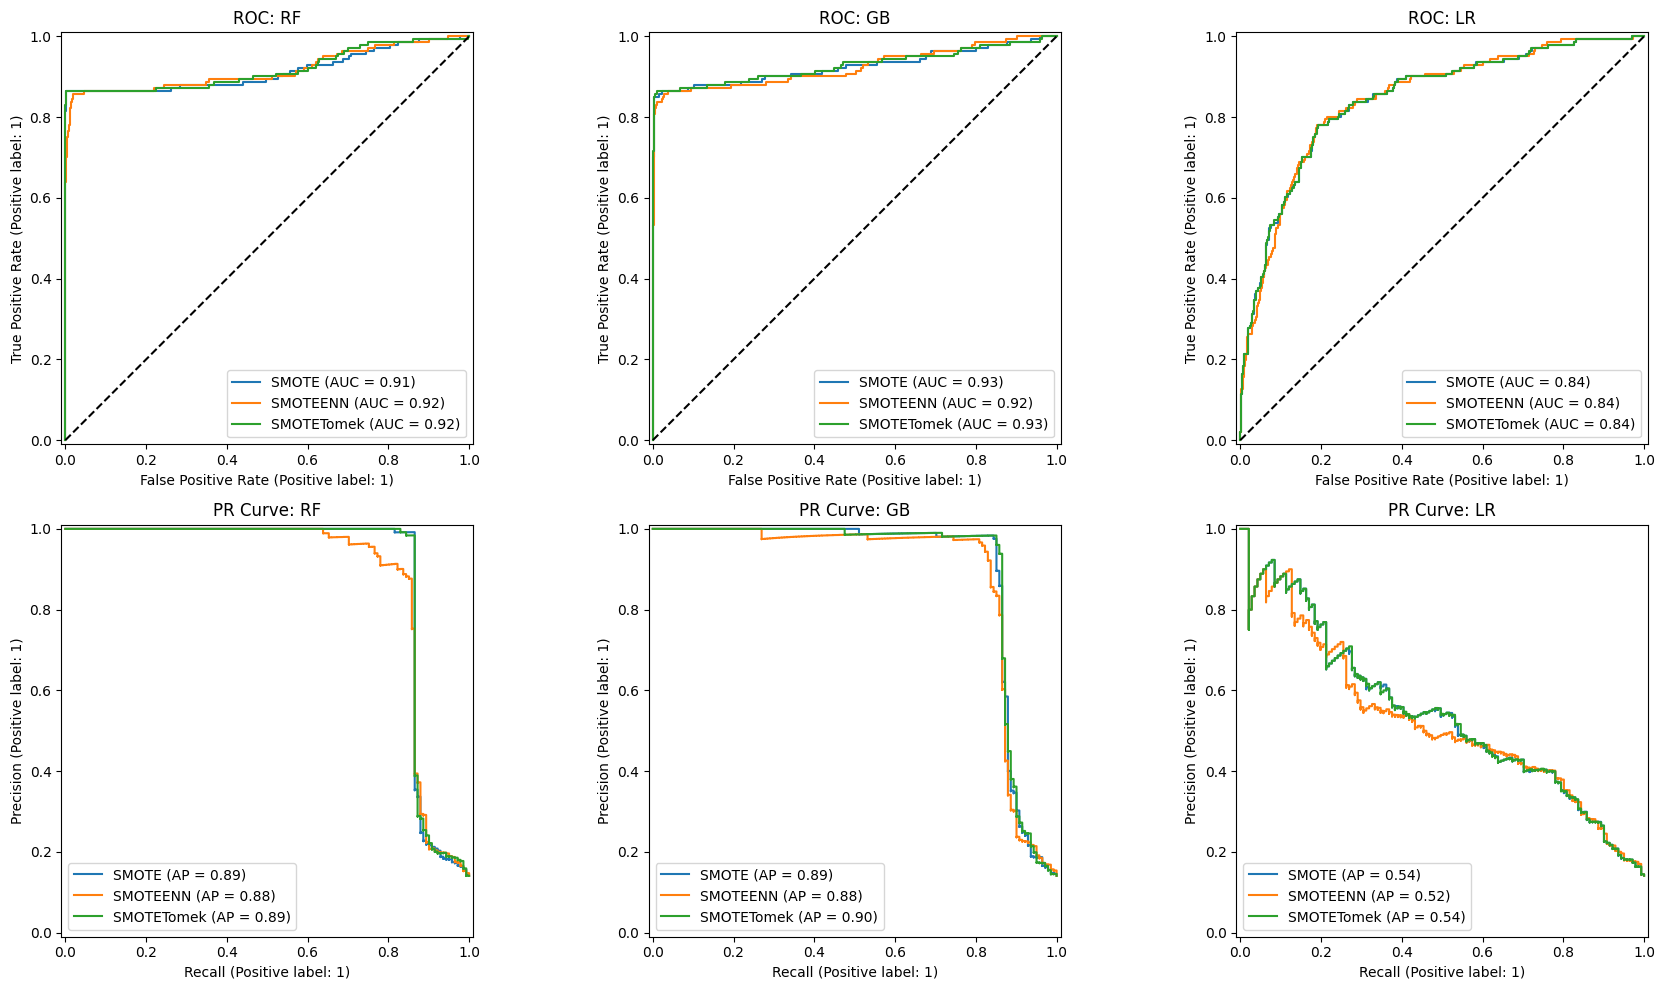

In [ ]:
# ============ PLOTS ============
# Confusion matrices
fig, axes = plt.subplots(len(models), len(samplers), figsize=(18,12))
for i,mname in enumerate(models.keys()):
    for j,sname in enumerate(samplers.keys()):
        ax = axes[i,j]
        r = next(r for r in all_results if r["model"]==mname and r["sampler"]==sname)
        ConfusionMatrixDisplay(r["confusion_matrix"]).plot(ax=ax, cmap="Blues", colorbar=False)
        ax.set_title(f"{mname}+{sname}")
plt.tight_layout()
plt.show()

# ROC and PR curves in subplots
fig, axes = plt.subplots(2,len(models), figsize=(18,10))

for i,mname in enumerate(models.keys()):
    # ROC
    ax = axes[0,i]
    for sname in samplers.keys():
        r = next(r for r in all_results if r["model"]==mname and r["sampler"]==sname)
        RocCurveDisplay.from_predictions(y_test, r["probs"], name=sname, ax=ax)
    ax.plot([0,1],[0,1],"k--")
    ax.set_title(f"ROC: {mname}")

    # Precision-Recall
    ax = axes[1,i]
    for sname in samplers.keys():
        r = next(r for r in all_results if r["model"]==mname and r["sampler"]==sname)
        PrecisionRecallDisplay.from_predictions(y_test, r["probs"], name=sname, ax=ax)
    ax.set_title(f"PR Curve: {mname}")

plt.tight_layout()
plt.show()


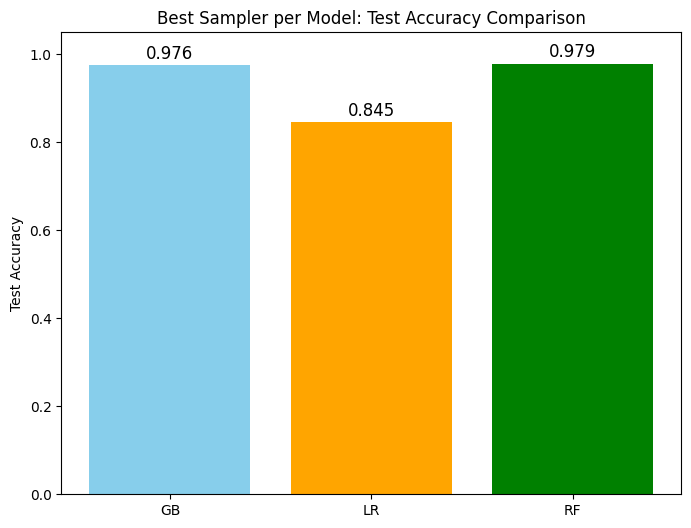

  model sampler  accuracy  cv_accuracy_mean  cv_accuracy_std
3    GB   SMOTE     0.976            0.9784         0.004716
6    LR   SMOTE     0.845            0.7952         0.020673
0    RF   SMOTE     0.979            0.9754         0.005869


In [ ]:
# ===== Compare best sampler per model and visualize test accuracy =====
best_results = summary_df.loc[summary_df.groupby('model')['accuracy'].idxmax()]
plt.figure(figsize=(8,6))
plt.bar(best_results['model'], best_results['accuracy'], color=['skyblue','orange','green'])
for i, acc in enumerate(best_results['accuracy']):
    plt.text(i, acc+0.005, f"{acc:.3f}", ha='center', va='bottom', fontsize=12)
plt.ylim(0, 1.05)
plt.ylabel("Test Accuracy")
plt.title("Best Sampler per Model: Test Accuracy Comparison")
plt.show()

print(best_results[['model','sampler','accuracy','cv_accuracy_mean','cv_accuracy_std']])



===== Best sampler for RF =====
Sampler: SMOTE
Classification Report:


array([[857,   2],
       [ 19, 122]])


===== Best sampler for GB =====
Sampler: SMOTE
Classification Report:


array([[856,   3],
       [ 21, 120]])


===== Best sampler for LR =====
Sampler: SMOTE
Classification Report:


array([[760,  99],
       [ 56,  85]])

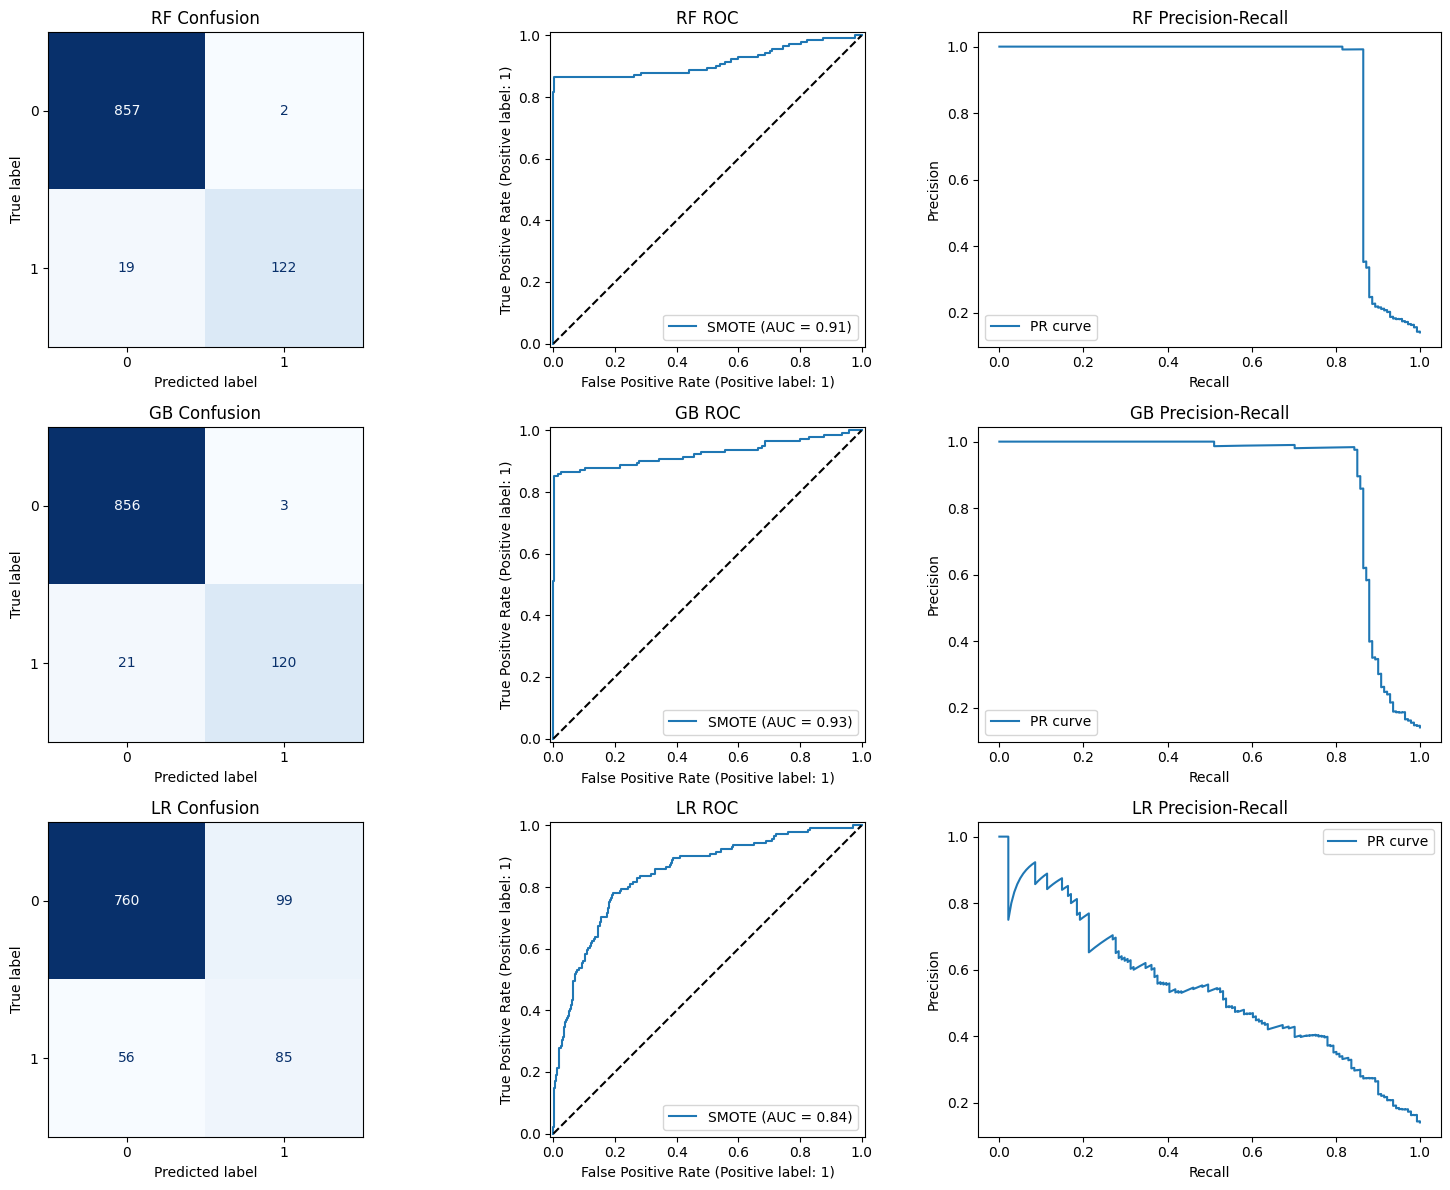

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve

best_results = {}
for model_name in ["RF", "GB", "LR"]:
    # Select row with highest F1
    subset = summary_df[summary_df["model"]==model_name]
    best_row = subset.loc[subset["f1"].idxmax()]
    best_results[model_name] = best_row

    # Print classification report
    print(f"\n===== Best sampler for {model_name} =====")
    print("Sampler:", best_row["sampler"])
    print("Classification Report:")
    display(best_row["confusion_matrix"])
    y_test_pred = best_row["confusion_matrix"]

# ============ Plot Confusion Matrix, ROC, PR ============

fig, axes = plt.subplots(3,3, figsize=(15,12))

for i, model_name in enumerate(["RF","GB","LR"]):
    best_row = best_results[model_name]
    sampler_name = best_row["sampler"]

    # Load pipeline
    pipeline_path = f"./artifacts/{model_name}_{sampler_name}_pipeline.pkl"
    pipe = joblib.load(pipeline_path)

    # Threshold tuning
    y_test_prob = pipe.predict_proba(X_test)[:,1]
    meta_path = f"./artifacts/{model_name}_{sampler_name}_meta.json"
    with open(meta_path,"r") as f:
        meta = json.load(f)
    best_threshold = meta.get("best_threshold",0.5)
    y_test_pred = (y_test_prob >= best_threshold).astype(int)

    # Confusion matrix
    ax = axes[i,0]
    ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_pred)).plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"{model_name} Confusion")

    # ROC
    ax = axes[i,1]
    RocCurveDisplay.from_predictions(y_test, y_test_prob, name=sampler_name, ax=ax)
    ax.plot([0,1],[0,1],"k--")
    ax.set_title(f"{model_name} ROC")

    # Precision-Recall
    ax = axes[i,2]
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)
    ax.plot(recall, precision, label="PR curve")
    ax.set_title(f"{model_name} Precision-Recall")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend()

plt.tight_layout()
plt.show()


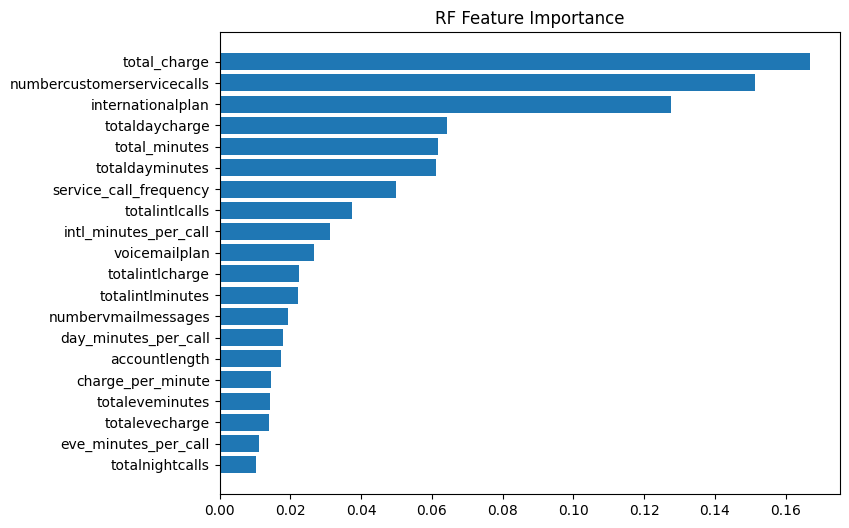

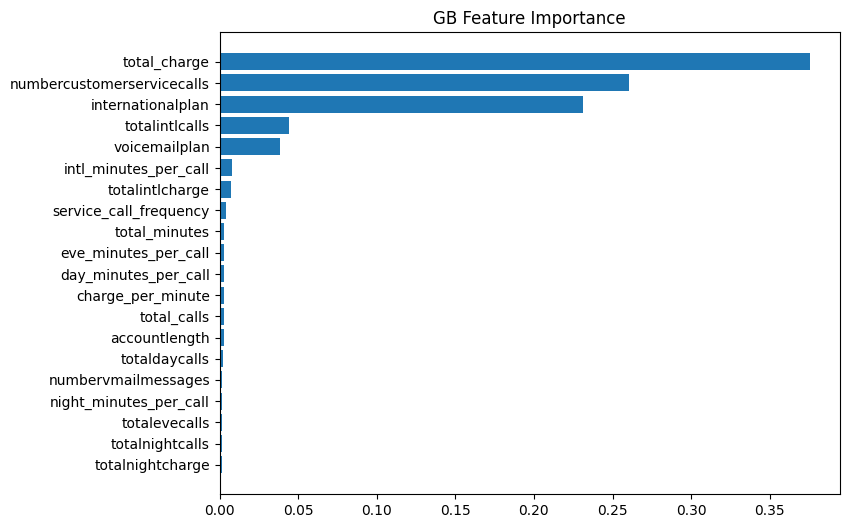

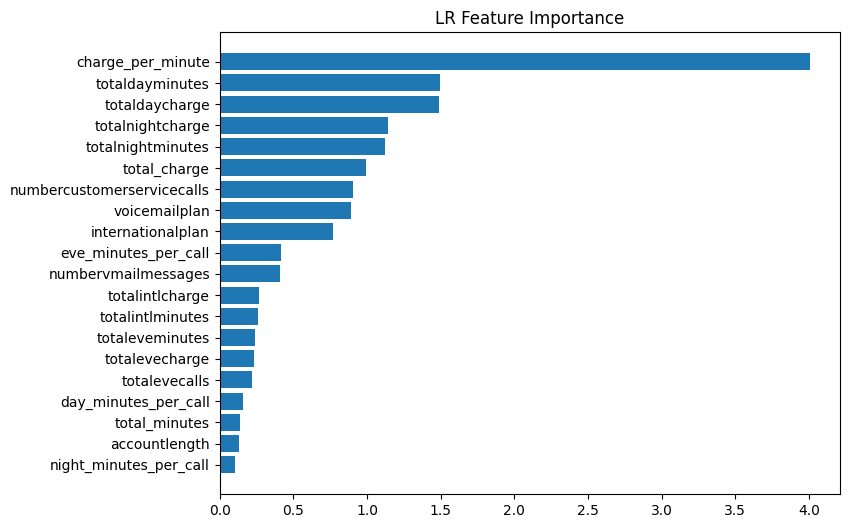

In [ ]:
# ============ Feature Importance ============
for model_name in ["RF","GB","LR"]:
    best_row = best_results[model_name]
    sampler_name = best_row["sampler"]
    pipe = joblib.load(f"./artifacts/{model_name}_{sampler_name}_pipeline.pkl")

    # Get feature names after preprocessing
    X_transformed = pipe.named_steps['preproc'].transform(X)
    if model_name == "LR":
        importances = np.abs(pipe.named_steps['clf'].coef_[0])
    else:
        importances = pipe.named_steps['clf'].feature_importances_

    # Plot top 20 features
    plt.figure(figsize=(8,6))
    indices = np.argsort(importances)[-20:]
    plt.barh(np.array(X.columns)[indices], importances[indices])
    plt.title(f"{model_name} Feature Importance")
    plt.show()


In [ ]:
import pandas as pd
import numpy as np
import os, joblib, json
from sklearn.model_selection import train_test_split


DATA_PATH = "./Churn-data-UCI Dataset(5000).csv"
TARGET = "churn"

df = pd.read_csv(DATA_PATH)
df = df.rename(columns=lambda c: c.strip())

# Binary encoding
df[TARGET] = df[TARGET].map({True:1, False:0, 'Yes':1, 'No':0, 'yes':1, 'no':0}).astype(int)
df['internationalplan'] = df['internationalplan'].map({True:1, False:0, 'yes':1, 'no':0}).fillna(0)
df['voicemailplan'] = df['voicemailplan'].map({True:1, False:0, 'yes':1, 'no':0}).fillna(0)

# Feature engineering
day_charge_cols = ['totaldaycharge','totalevecharge','totalnightcharge','totalintlcharge']
min_cols = ['totaldayminutes','totaleveminutes','totalnightminutes','totalintlminutes']
call_cols = ['totaldaycalls','totalevecalls','totalnightcalls','totalintlcalls']

df['total_charge'] = df[day_charge_cols].sum(axis=1)
df['total_minutes'] = df[min_cols].sum(axis=1)
df['total_calls'] = df[call_cols].sum(axis=1)
df['day_minutes_per_call'] = df['totaldayminutes'] / (df['totaldaycalls'] + 1e-5)
df['eve_minutes_per_call'] = df['totaleveminutes'] / (df['totalevecalls'] + 1e-5)
df['night_minutes_per_call'] = df['totalnightminutes'] / (df['totalnightcalls'] + 1e-5)
df['intl_minutes_per_call'] = df['totalintlminutes'] / (df['totalintlcalls'] + 1e-5)
df['service_call_frequency'] = df['numbercustomerservicecalls'] / (df['accountlength']+1)
df['charge_per_minute'] = df['total_charge'] / (df['total_minutes']+1e-5)

# Fill missing numeric values
for c in df.select_dtypes(include=[np.number]).columns:
    df[c] = df[c].fillna(df[c].median())

X = df.drop(columns=[TARGET])
y = df[TARGET]

# Train-test split
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=RANDOM_STATE)

print("✅ Data loaded and feature-engineered.")

SAVE_DIR = "./artifacts"
models = ["RF","GB","LR"]
pipelines, metas = {}, {}

for m in models:
    pipeline_path = os.path.join(SAVE_DIR, f"{m}_SMOTE_pipeline.pkl")
    meta_path = os.path.join(SAVE_DIR, f"{m}_SMOTE_meta.json")

    pipelines[m] = joblib.load(pipeline_path)
    with open(meta_path,"r") as f:
        metas[m] = json.load(f)
    print(f"✅ Loaded {m}_SMOTE pipeline with threshold {metas[m].get('best_threshold',0.5)}")



✅ Data loaded and feature-engineered.
✅ Loaded RF_SMOTE pipeline with threshold 0.5143916227534648
✅ Loaded GB_SMOTE pipeline with threshold 0.5621889639903999
✅ Loaded LR_SMOTE pipeline with threshold 0.6498322899999766


,Model,Threshold,Targeted,Retained,Missed,Benefit($),Cost($),Net Profit($),ROI(%),Profit per Customer($)
0,RF,0.514392,631,629,78,62900,6310,56590,896.830428,11.318
1,GB,0.562189,617,614,93,61400,6170,55230,895.137763,11.046
2,LR,0.649832,965,444,263,44400,9650,34750,360.103627,6.950


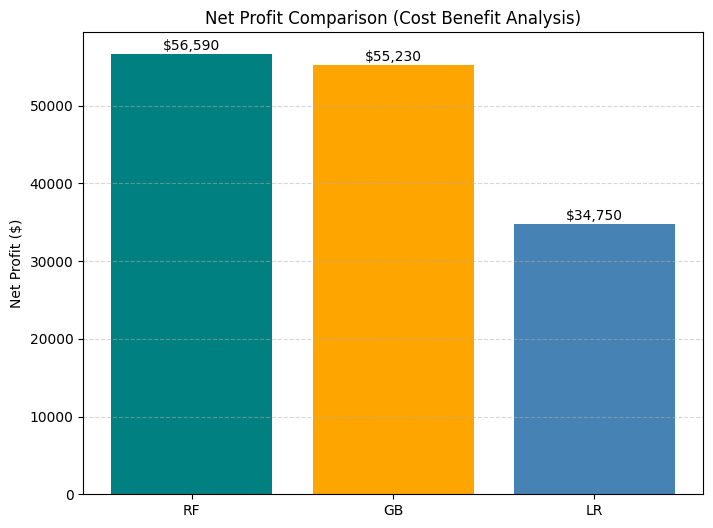

🏆 Best Model for Business: RF


In [ ]:
# ============ BUSINESS-FRIENDLY COST BENEFIT ANALYSIS + SUMMARY ============
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

profit_per_retained = 100
cost_per_contact = 10

cba_records = []

for m in models:
    pipe = pipelines[m]
    meta = metas[m]
    threshold = meta.get("best_threshold",0.5)

    y_prob = pipe.predict_proba(X)[:,1]
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    targeted = tp + fp
    retained = tp
    missed = fn
    benefit = retained*profit_per_retained
    cost = targeted*cost_per_contact
    net_profit = benefit - cost
    roi = (net_profit / cost)*100 if cost>0 else 0
    profit_per_customer = net_profit / len(y)

    cba_records.append({
        "Model": m,
        "Threshold": threshold,
        "Targeted": targeted,
        "Retained": retained,
        "Missed": missed,
        "Benefit($)": benefit,
        "Cost($)": cost,
        "Net Profit($)": net_profit,
        "ROI(%)": roi,
        "Profit per Customer($)": profit_per_customer
    })

cba_df = pd.DataFrame(cba_records)
cba_df = cba_df.sort_values("Net Profit($)", ascending=False)
display(cba_df)

# Plot Net Profit
plt.figure(figsize=(8,6))
bars = plt.bar(cba_df["Model"], cba_df["Net Profit($)"], color=["teal","orange","steelblue"])
plt.title("Net Profit Comparison (Cost Benefit Analysis)")
plt.ylabel("Net Profit ($)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
for bar,val in zip(bars,cba_df["Net Profit($)"]):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+500,f"${val:,.0f}",ha='center')
plt.show()

print(f"🏆 Best Model for Business: {cba_df.iloc[0]['Model']}")





In [ ]:
# =========================
# 💼 Business-Friendly Churn Prediction Project
# =========================

import os, json, joblib
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# -------------------------
# Configuration
# -------------------------
SAVE_DIR = "./artifacts"
DATA_PATH = "./Churn-data-UCI Dataset(5000).csv"
TARGET = "churn"

PROFIT_PER_RETAINED = 100
COST_PER_CONTACT = 10
BEST_MODEL = "RF"
BEST_SAMPLER = "SMOTE"
BEST_THRESHOLD = 0.514

RANDOM_STATE = 42

# -------------------------
# Load dataset
# -------------------------
df = pd.read_csv(DATA_PATH)
df = df.rename(columns=lambda c: c.strip())

# Binary encoding
df[TARGET] = df[TARGET].map({True:1, False:0, 'Yes':1, 'No':0, 'yes':1, 'no':0}).astype(int)
df['internationalplan'] = df['internationalplan'].map({True:1, False:0, 'yes':1, 'no':0}).fillna(0)
df['voicemailplan'] = df['voicemailplan'].map({True:1, False:0, 'yes':1, 'no':0}).fillna(0)

# Feature Engineering
day_charge_cols = ['totaldaycharge','totalevecharge','totalnightcharge','totalintlcharge']
min_cols = ['totaldayminutes','totaleveminutes','totalnightminutes','totalintlminutes']
call_cols = ['totaldaycalls','totalevecalls','totalnightcalls','totalintlcalls']

df['total_charge'] = df[day_charge_cols].sum(axis=1)
df['total_minutes'] = df[min_cols].sum(axis=1)
df['total_calls'] = df[call_cols].sum(axis=1)
df['day_minutes_per_call'] = df['totaldayminutes'] / (df['totaldaycalls'] + 1e-5)
df['eve_minutes_per_call'] = df['totaleveminutes'] / (df['totalevecalls'] + 1e-5)
df['night_minutes_per_call'] = df['totalnightminutes'] / (df['totalnightcalls'] + 1e-5)
df['intl_minutes_per_call'] = df['totalintlminutes'] / (df['totalintlcalls'] + 1e-5)
df['service_call_frequency'] = df['numbercustomerservicecalls'] / (df['accountlength']+1)
df['charge_per_minute'] = df['total_charge'] / (df['total_minutes']+1e-5)

# Fill missing numeric values
for c in df.select_dtypes(include=[np.number]).columns:
    df[c] = df[c].fillna(df[c].median())

X = df.drop(columns=[TARGET])
y = df[TARGET]

# -------------------------
# Load trained pipeline
# -------------------------
pipeline_path = os.path.join(SAVE_DIR, f"{BEST_MODEL}_{BEST_SAMPLER}_pipeline.pkl")
meta_path = os.path.join(SAVE_DIR, f"{BEST_MODEL}_{BEST_SAMPLER}_meta.json")

pipe = joblib.load(pipeline_path)
with open(meta_path, "r") as f:
    meta = json.load(f)
best_threshold = meta.get("best_threshold", BEST_THRESHOLD)

print(f"✅ Loaded pipeline: {BEST_MODEL} + {BEST_SAMPLER} | Threshold={best_threshold}")

# -------------------------
# Bulk Test Set Predictions + CBA
# -------------------------
y_prob = pipe.predict_proba(X)[:,1]
y_pred = (y_prob >= best_threshold).astype(int)

tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
targeted = tp + fp
retained = tp
missed = fn
benefit = retained * PROFIT_PER_RETAINED
cost = targeted * COST_PER_CONTACT
net_profit = benefit - cost
roi = (net_profit / cost) * 100 if cost>0 else 0
profit_per_customer = net_profit / len(y)

print("\n===== 💰 COST-BENEFIT SUMMARY =====")
print(f"Targeted Customers: {targeted}")
print(f"Retained Churners: {retained}")
print(f"Missed Churners: {missed}")
print(f"Benefit: ${benefit:,}")
print(f"Cost: ${cost:,}")
print(f"Net Profit: ${net_profit:,}")
print(f"ROI: {roi:.1f}%")
print(f"Profit per Customer: ${profit_per_customer:.2f}")

# High-risk customers
high_risk_customers = pd.DataFrame(X)
high_risk_customers["churn_prob"] = y_prob
high_risk_customers["action_needed"] = y_pred
high_risk_customers = high_risk_customers.sort_values(by="churn_prob", ascending=False)
print("\n📌 Top 10 High-Risk Customers:")
display(high_risk_customers.head(10))



✅ Loaded pipeline: RF + SMOTE | Threshold=0.5143916227534648

===== 💰 COST-BENEFIT SUMMARY =====
Targeted Customers: 631
Retained Churners: 629
Missed Churners: 78
Benefit: $62,900
Cost: $6,310
Net Profit: $56,590
ROI: 896.8%
Profit per Customer: $11.32

📌 Top 10 High-Risk Customers:


,accountlength,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,...,total_minutes,total_calls,day_minutes_per_call,eve_minutes_per_call,night_minutes_per_call,intl_minutes_per_call,service_call_frequency,charge_per_minute,churn_prob,action_needed
4943,132,0,0,0,265.8,122,45.19,285.1,90,24.23,...,748.1,345,2.178688,3.167777,1.480645,1.511109,0.015038,0.108742,0.999969,1
2113,60,0,0,0,289.8,101,49.27,255.6,115,21.73,...,799.9,296,2.869307,2.222609,3.194736,2.924993,0.032787,0.106376,0.999961,1
2119,111,0,0,0,249.8,109,42.47,242.4,106,20.60,...,735.6,297,2.291743,2.286792,2.971794,2.899993,0.000000,0.104173,0.999961,1
3265,82,0,0,0,266.9,83,45.37,229.7,74,19.52,...,759.3,262,3.215662,3.104054,2.542424,1.833330,0.036145,0.104293,0.999960,1
3457,73,0,0,0,272.4,112,46.31,252.2,91,21.44,...,790.9,320,2.432143,2.771428,2.280357,2.179996,0.013514,0.103907,0.999954,1
552,44,0,0,0,288.1,112,48.98,258.0,92,21.93,...,748.7,298,2.572321,2.804348,2.137778,2.549994,0.066667,0.109951,0.999952,1
4918,110,0,0,0,272.5,113,46.33,288.9,113,24.56,...,743.9,327,2.411504,2.556637,1.795833,2.019996,0.018018,0.109396,0.999943,1
832,87,0,0,0,322.5,106,54.83,204.6,93,17.39,...,722.7,331,3.042453,2.200000,1.454687,2.349994,0.022727,0.115041,0.999927,1
2038,136,0,0,0,269.8,106,45.87,228.8,101,19.45,...,766.2,321,2.545283,2.265346,2.429245,1.262498,0.007299,0.103942,0.999920,1
306,113,0,0,0,272.1,111,46.26,268.5,118,22.82,...,762.9,344,2.451351,2.275424,2.036190,0.849999,0.008772,0.106174,0.999920,1


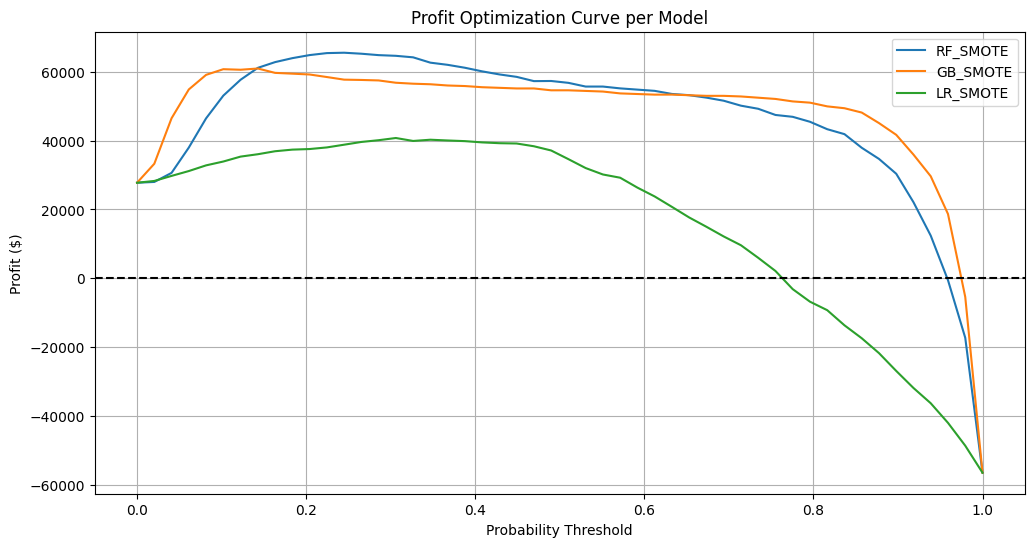

📊 Profit Optimization Summary:


,Model,Sampler,Meta_Threshold,Profit_Optimal_Threshold,Max_Profit
0,RF,SMOTE,0.514392,0.245,65580
1,GB,SMOTE,0.562189,0.143,60990
2,LR,SMOTE,0.649832,0.306,40780



🏆 Best Model for Profit: RF + SMOTE
💰 Max Profit: $65,580 at Threshold=0.245
📌 Meta Threshold used in pipeline: 0.5143916227534648


In [ ]:
# ==============================
# 💹 Profit Optimization Curve
# ==============================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import joblib

# Business assumptions
profit_per_retained = 100
cost_per_contact = 10
loss_per_missed = 80

# Thresholds to evaluate
thresholds = np.linspace(0, 1, 50)

profit_summary = []

plt.figure(figsize=(12,6))

for model_name in ["RF","GB","LR"]:
    sampler_name = "SMOTE"

    # Load pipeline and meta
    pipe = joblib.load(f"./artifacts/{model_name}_{sampler_name}_pipeline.pkl")
    meta = metas[model_name] # Corrected access to meta

    # Predicted probabilities
    y_prob = pipe.predict_proba(X)[:,1]

    # Compute profits for all thresholds
    profits = []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        profit = tp*profit_per_retained - fp*cost_per_contact - fn*loss_per_missed
        profits.append(profit)

    profits = np.array(profits)
    plt.plot(thresholds, profits, label=f"{model_name}_{sampler_name}")

    # Best threshold and max profit
    best_idx = np.argmax(profits)
    best_t = thresholds[best_idx]
    max_profit = profits[best_idx]

    profit_summary.append({
        "Model": model_name,
        "Sampler": sampler_name,
        "Meta_Threshold": meta.get("best_threshold",0.5),
        "Profit_Optimal_Threshold": round(best_t,3),
        "Max_Profit": round(max_profit,2)
    })

# Plot formatting
plt.axhline(0, color="black", linestyle="--")
plt.xlabel("Probability Threshold")
plt.ylabel("Profit ($)")
plt.title("Profit Optimization Curve per Model")
plt.grid(True)
plt.legend()
plt.show()

# Profit optimization summary table
profit_summary_df = pd.DataFrame(profit_summary).sort_values("Max_Profit", ascending=False)
print("📊 Profit Optimization Summary:")
display(profit_summary_df)

# Identify the best model by max profit
best_model = profit_summary_df.iloc[0]
print(f"\n🏆 Best Model for Profit: {best_model['Model']} + {best_model['Sampler']}")
print(f"💰 Max Profit: ${best_model['Max_Profit']:,} at Threshold={best_model['Profit_Optimal_Threshold']}")
print(f"📌 Meta Threshold used in pipeline: {best_model['Meta_Threshold']}")


===== SHAP Explanation for RF_SMOTE =====
Global SHAP - Beeswarm & Bar Plots


<Figure size 1200x600 with 0 Axes>

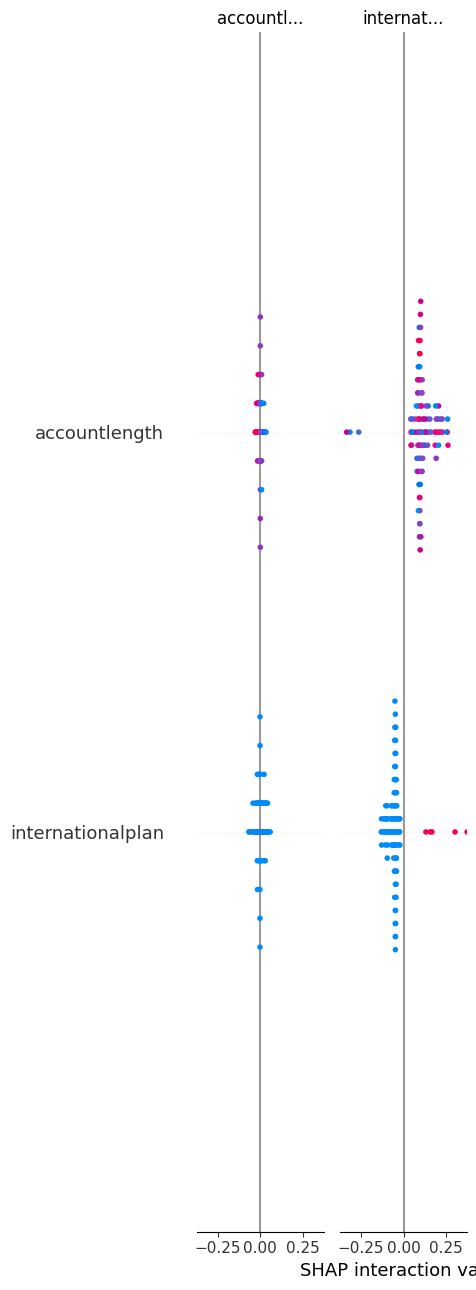

Saved Beeswarm plot: shap_plots/RF_SMOTE_global_beeswarm.png


<Figure size 1000x600 with 0 Axes>

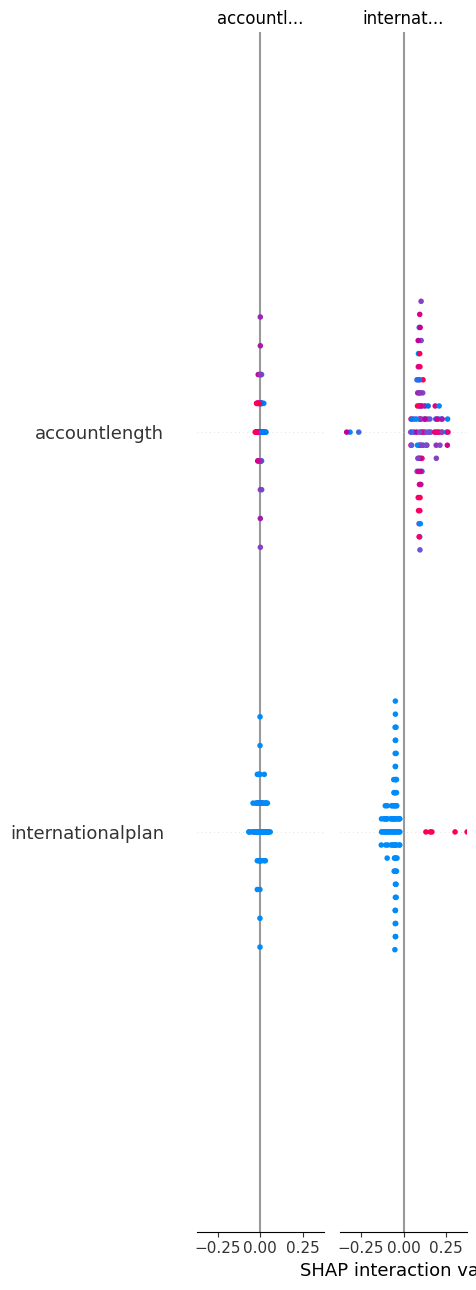

Saved Bar plot: shap_plots/RF_SMOTE_global_bar.png
Local SHAP - Instance 0


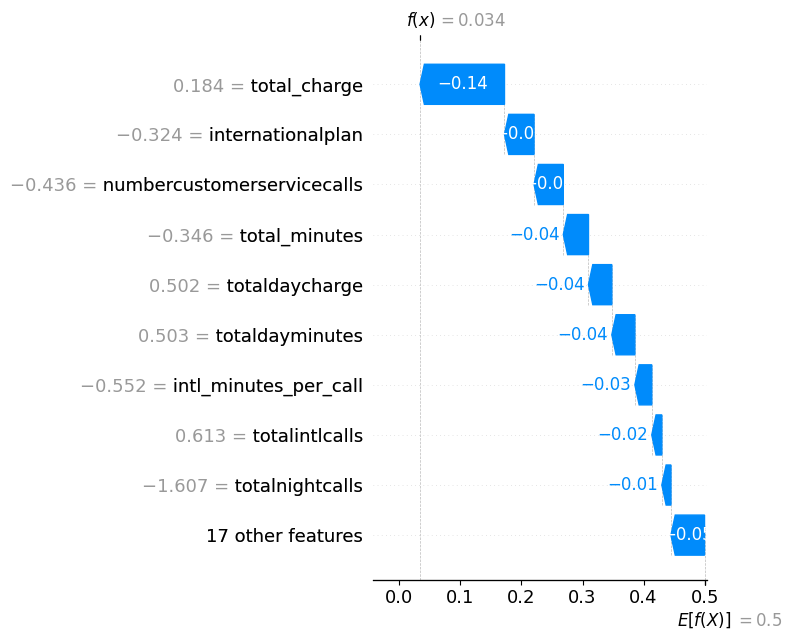

Saved Waterfall plot: shap_plots/RF_SMOTE_local_waterfall_0.png


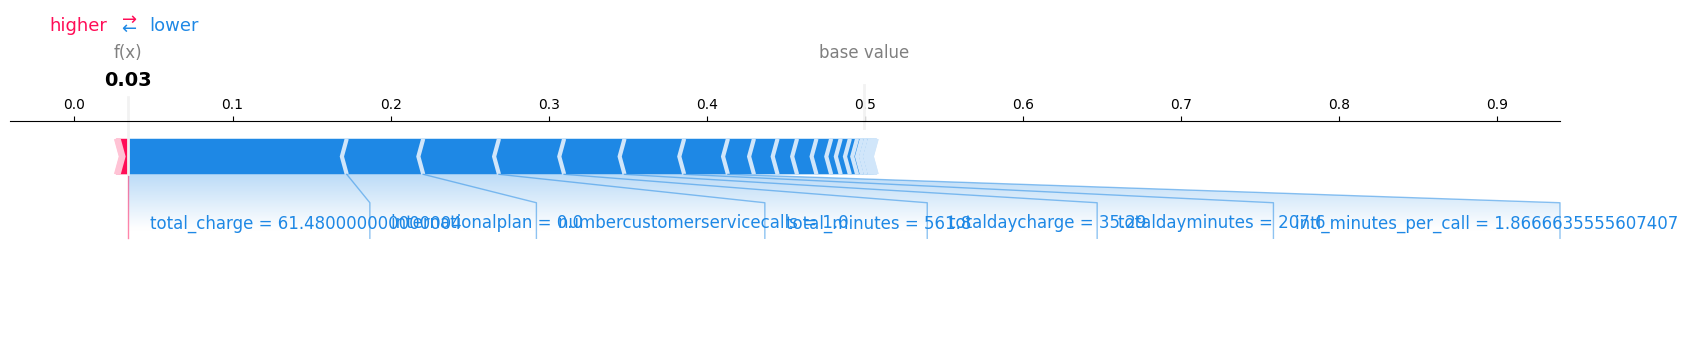

None

Force plot displayed interactively (matplotlib version can be saved separately if needed)

===== SHAP Explanation for GB_SMOTE =====
Global SHAP - Beeswarm & Bar Plots


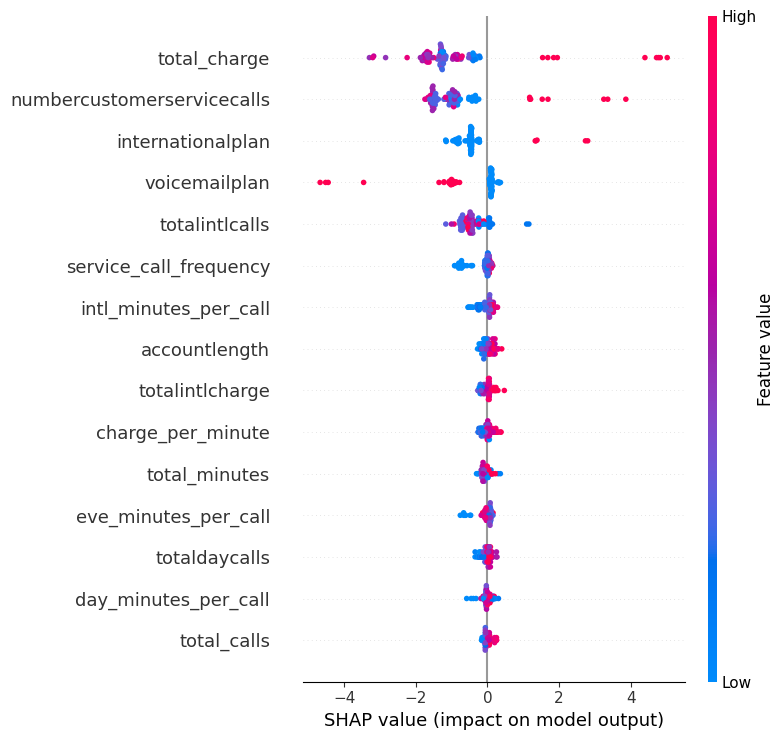

Saved Beeswarm plot: shap_plots/GB_SMOTE_global_beeswarm.png


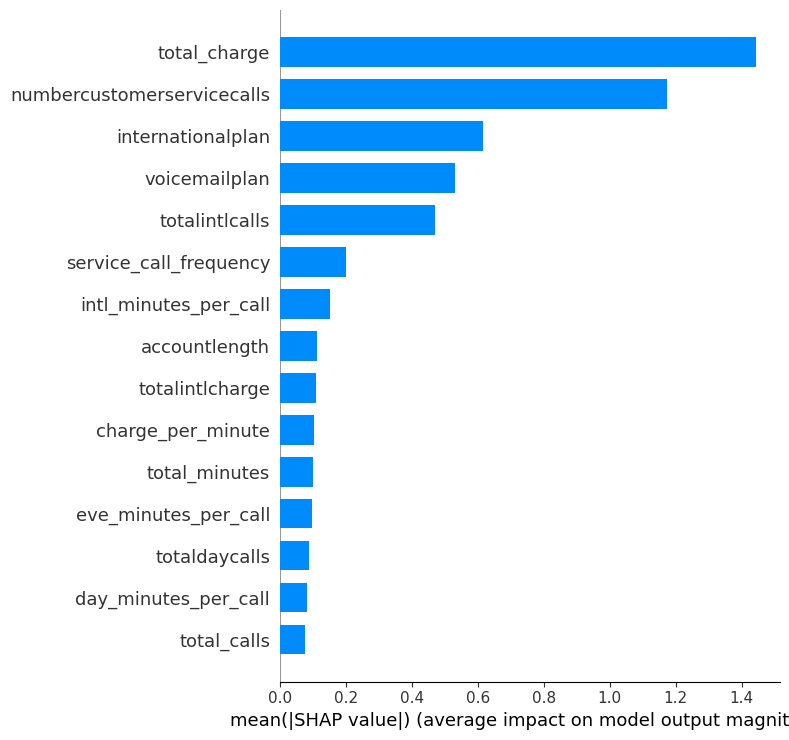

Saved Bar plot: shap_plots/GB_SMOTE_global_bar.png
Local SHAP - Instance 0


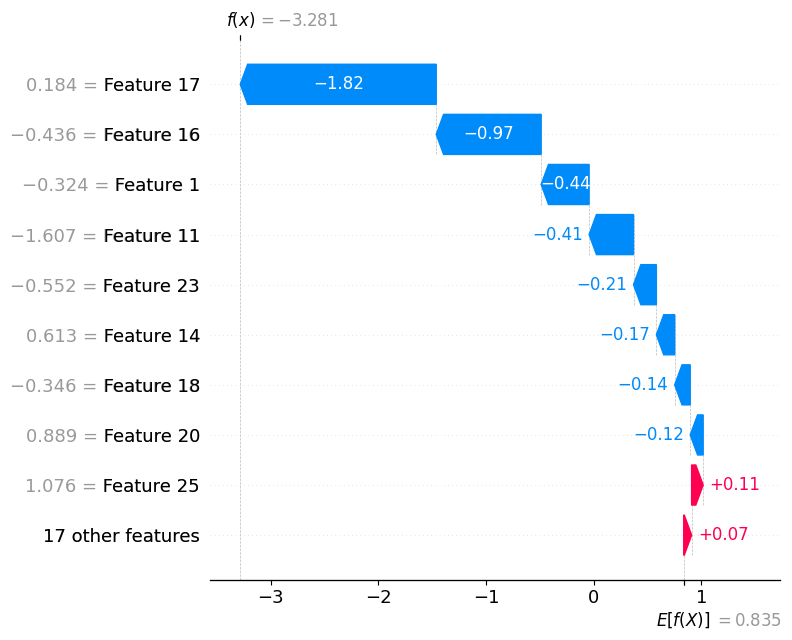

Saved Waterfall plot: shap_plots/GB_SMOTE_local_waterfall_0.png


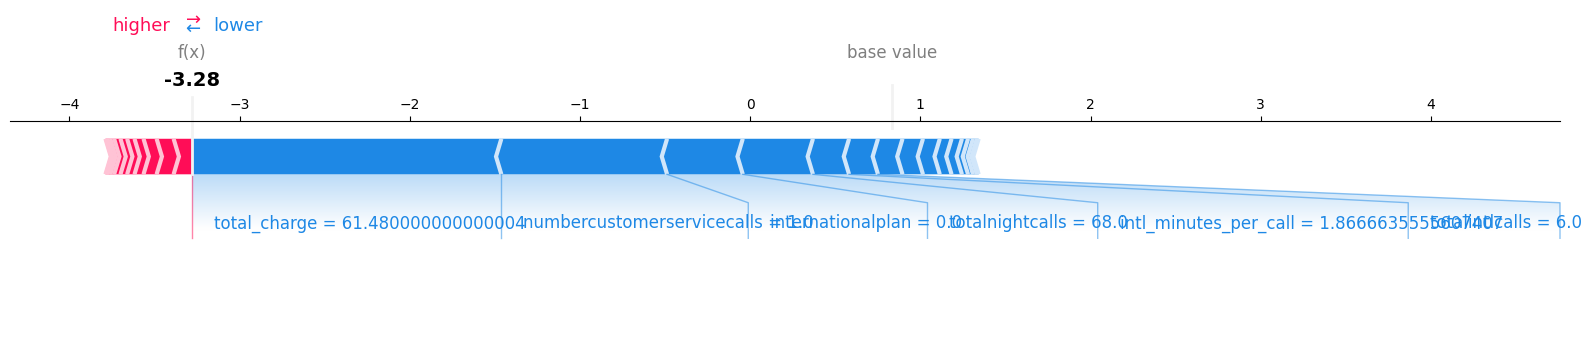

None

Force plot displayed interactively (matplotlib version can be saved separately if needed)

===== SHAP Explanation for LR_SMOTE =====
Global SHAP - Beeswarm & Bar Plots


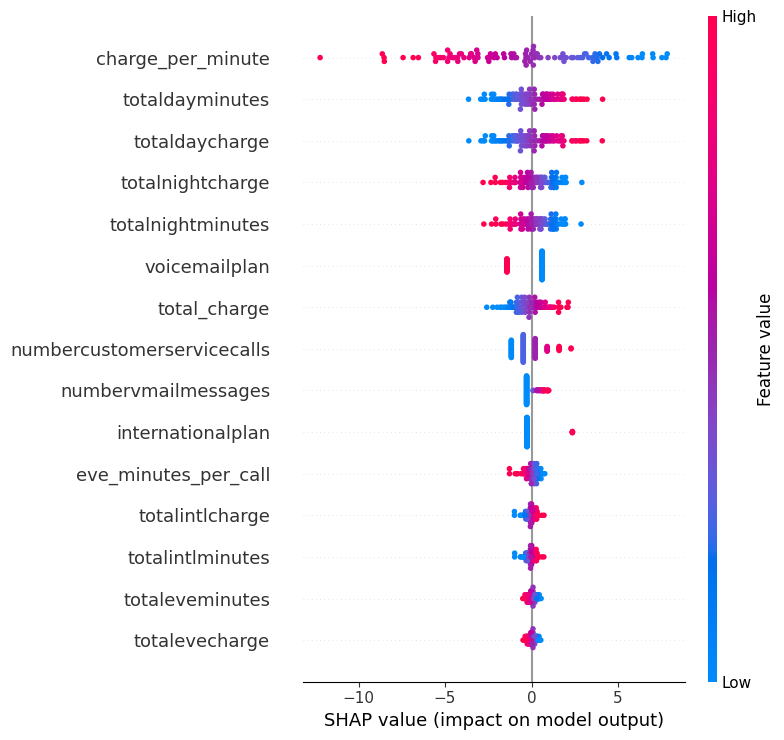

Saved Beeswarm plot: shap_plots/LR_SMOTE_global_beeswarm.png


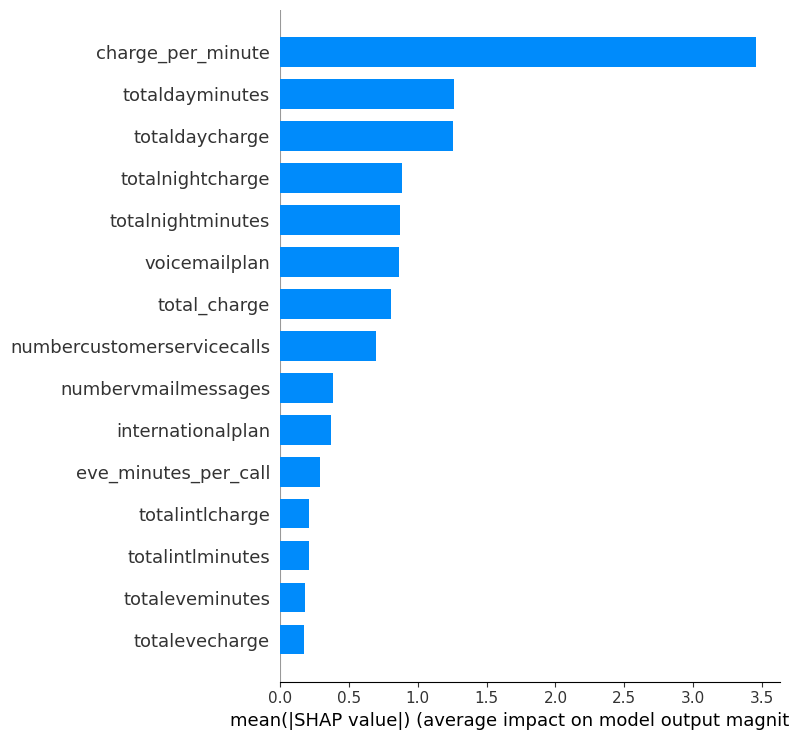

Saved Bar plot: shap_plots/LR_SMOTE_global_bar.png
Local SHAP - Instance 0


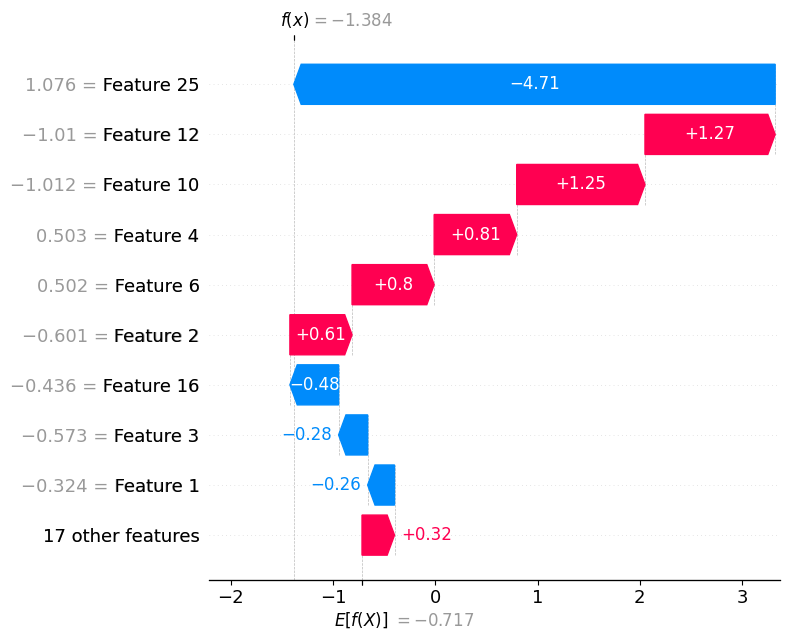

Saved Waterfall plot: shap_plots/LR_SMOTE_local_waterfall_0.png


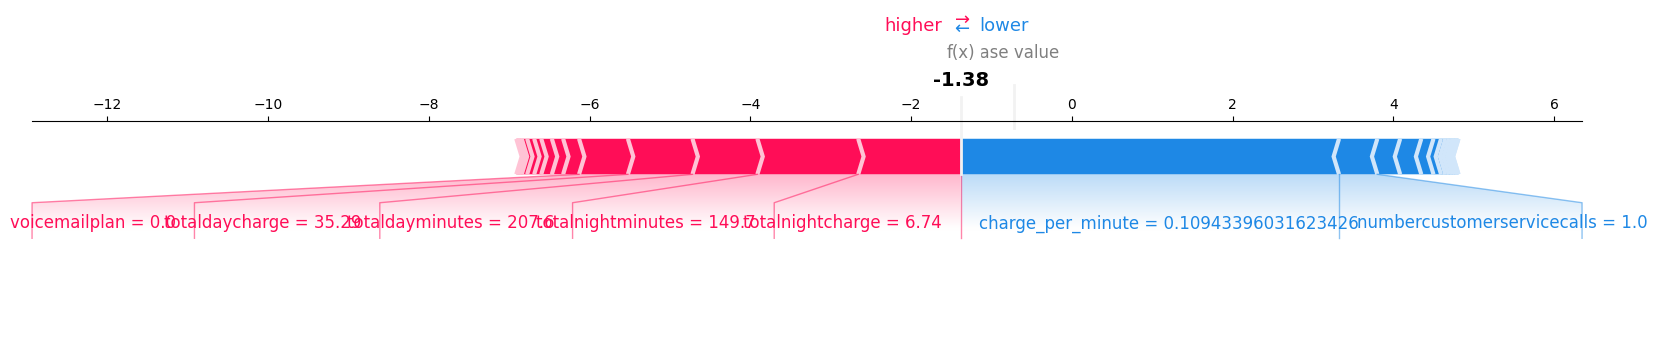

None

Force plot displayed interactively (matplotlib version can be saved separately if needed)


In [ ]:
# ==============================
# SHAP
# ==============================
from IPython.display import display
import shap
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os

def explain_with_shap(pipeline, model_name, X_train, X_test,
                      num_samples=100, instance_idx=0,
                      max_display_global=15, max_display_local=10,
                      save_dir="shap_plots"):
    """
    Explain a fitted pipeline using SHAP and optionally save plots.
    """
    # Create directory if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    print(f"\n===== SHAP Explanation for {model_name} =====")

    # Sample for speed
    X_sample = X_test.sample(min(num_samples, len(X_test)), random_state=42)
    if instance_idx >= len(X_sample):
        instance_idx = 0

    # Extract classifier and preprocessor
    model = pipeline.named_steps['clf']
    preprocessor = [step for name, step in pipeline.named_steps.items() if name not in ['clf', 'resample']][0]

    # Transform features
    X_train_trans = preprocessor.transform(X_train)
    X_sample_trans = preprocessor.transform(X_sample)

    # SHAP explainer
    model_type = str(type(model))
    if hasattr(model, "predict_proba") and ("Forest" in model_type or "Boost" in model_type):
        explainer = shap.TreeExplainer(model)
    elif "LogisticRegression" in model_type:
        explainer = shap.LinearExplainer(model, X_train_trans, feature_perturbation="interventional")
    else:
        explainer = shap.Explainer(model, X_train_trans)

    # Compute SHAP values
    shap_values = explainer(X_sample_trans)

    # -------------------------
    # Global SHAP plots
    # -------------------------
    print("Global SHAP - Beeswarm & Bar Plots")

    # Beeswarm
    plt.figure(figsize=(12, 6))
    shap.summary_plot(
        shap_values,
        X_sample_trans,
        feature_names=X_train.columns,
        max_display=max_display_global,
        show=False
    )
    plt.tight_layout()
    beeswarm_path = os.path.join(save_dir, f"{model_name}_global_beeswarm.png")
    plt.savefig(beeswarm_path, dpi=300)
    plt.show()
    print(f"Saved Beeswarm plot: {beeswarm_path}")

    # Bar plot
    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values,
        X_sample_trans,
        feature_names=X_train.columns,
        plot_type="bar",
        max_display=max_display_global,
        show=False
    )
    plt.tight_layout()
    bar_path = os.path.join(save_dir, f"{model_name}_global_bar.png")
    plt.savefig(bar_path, dpi=300)
    plt.show()
    print(f"Saved Bar plot: {bar_path}")

    # -------------------------
    # Local SHAP plots
    # -------------------------
    print(f"Local SHAP - Instance {instance_idx}")
    shap_instance = shap_values[instance_idx]

    # Handle binary classifier
    if shap_instance.values.ndim == 2 and shap_instance.values.shape[1] == 2:
        from shap import Explanation
        shap_instance = Explanation(
            values=shap_instance.values[:, 1],
            base_values=shap_instance.base_values[1],
            data=shap_instance.data,
            feature_names=X_train.columns
        )

    # Waterfall plot
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(shap_instance, max_display=max_display_local, show=False)
    plt.tight_layout()
    waterfall_path = os.path.join(save_dir, f"{model_name}_local_waterfall_{instance_idx}.png")
    plt.savefig(waterfall_path, dpi=300)
    plt.show()
    print(f"Saved Waterfall plot: {waterfall_path}")

    # Force plot (matplotlib)
    shap.initjs()
    force_path = os.path.join(save_dir, f"{model_name}_local_force_{instance_idx}.png")
    display(
        shap.force_plot(
            shap_instance.base_values,
            shap_instance.values,
            X_sample.iloc[instance_idx, :],
            matplotlib=True
        )
    )
    print(f"Force plot displayed interactively (matplotlib version can be saved separately if needed)")


# -------------------------
# Example usage
# -------------------------
explain_with_shap(pipelines["RF"], "RF_SMOTE", X_train, X_test)
explain_with_shap(pipelines["GB"], "GB_SMOTE", X_train, X_test)
explain_with_shap(pipelines["LR"], "LR_SMOTE", X_train, X_test)

In [ ]:
# ============ Real-Time Prediction ============

def complete_customer_features(customer_dict):
    df_c = pd.DataFrame([customer_dict])
    df_c['total_charge'] = df_c[day_charge_cols].sum(axis=1)
    df_c['total_minutes'] = df_c[min_cols].sum(axis=1)
    df_c['total_calls'] = df_c[call_cols].sum(axis=1)
    df_c['day_minutes_per_call'] = df_c['totaldayminutes'] / (df_c['totaldaycalls']+1e-5)
    df_c['eve_minutes_per_call'] = df_c['totaleveminutes'] / (df_c['totalevecalls']+1e-5)
    df_c['night_minutes_per_call'] = df_c['totalnightminutes'] / (df_c['totalnightcalls']+1e-5)
    df_c['intl_minutes_per_call'] = df_c['totalintlminutes'] / (df_c['totalintlcalls']+1e-5)
    df_c['service_call_frequency'] = df_c['numbercustomerservicecalls'] / (df_c['accountlength']+1)
    df_c['charge_per_minute'] = df_c['total_charge'] / (df_c['total_minutes']+1e-5)
    for col in X.columns:
        if col not in df_c.columns:
            df_c[col] = X[col].median()
    return df_c[X.columns]

def predict_single_customer(customer_dict, pipe, meta):
    df_c = complete_customer_features(customer_dict)
    prob = pipe.predict_proba(df_c)[:,1][0]
    threshold = meta.get("best_threshold",0.5)

    risk = "LOW"
    actions = [" → Continue with excellent service delivery",
               " → Include in general loyalty programs"]

    if prob>0.7:
        risk="HIGH"
        actions = [" → Assign to dedicated retention team",
                   " → Offer personalized retention package",
                   " → Schedule immediate follow-up call"]
    elif prob>0.4:
        risk="MEDIUM"
        actions = [" → Add to watchlist for regular check-ins",
                   " → Send satisfaction survey",
                   " → Offer small incentive to stay"]

    print(f"\n👤 EXAMPLE CUSTOMER PREDICTION")
    print(f"📊 Churn Probability: {prob:.3f}")
    print(f"⚠️ RISK LEVEL: {risk}")
    for a in actions: print(a)

example_customer = {
    'accountlength': 120,'internationalplan':1,'voicemailplan':0,'numbervmailmessages':5,
    'totaldayminutes':200,'totaldaycalls':80,'totaldaycharge':30,
    'totaleveminutes':180,'totalevecalls':90,'totalevecharge':20,
    'totalnightminutes':150,'totalnightcalls':70,'totalnightcharge':15,
    'totalintlminutes':15,'totalintlcalls':10,'totalintlcharge':5,
    'numbercustomerservicecalls':1
}

predict_single_customer(example_customer, pipelines["RF"], metas["RF"])



👤 EXAMPLE CUSTOMER PREDICTION
📊 Churn Probability: 0.702
⚠️ RISK LEVEL: HIGH
 → Assign to dedicated retention team
 → Offer personalized retention package
 → Schedule immediate follow-up call
